Dataset loaded successfully.
Initial dataset shape: (32561, 15)
Dropped 'fnlwgt' column.
Dataset shape after handling missing values: (32561, 14)
Dataset columns being used: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Converted all columns to string type for marginal processing.

Starting DPSyn process with:
  Total epsilon: 1.0
  Number of 2-way marginals: 10
  Epsilon per marginal: 0.1000

Step 1&2: Generating 10 noisy 2-way marginals...

Step 3: Applying marginals to generate synthetic data...

Synthetic dataset generated and saved as 'c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv'
Synthetic dataset shape: (32561, 14)

--- Verifying Column Structure ---
Original Data Columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital

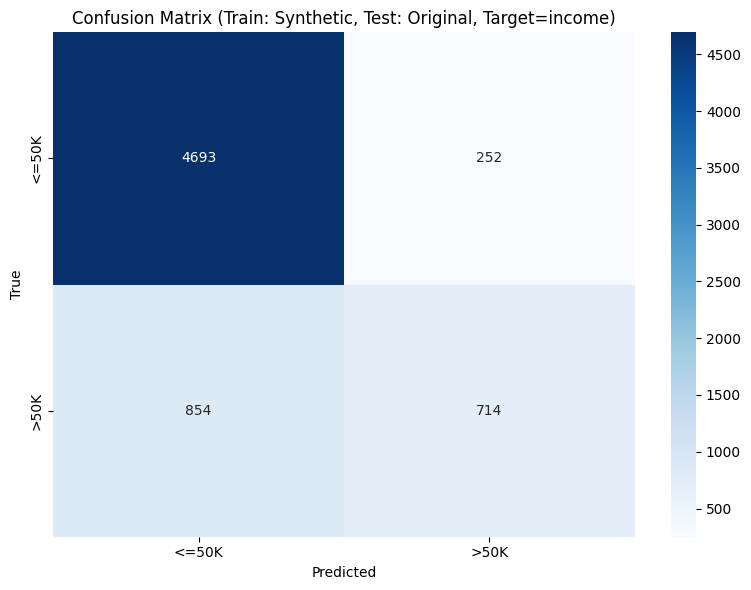

Saved ROC curve plot as 'roc_curve_synthetic_trained.png'


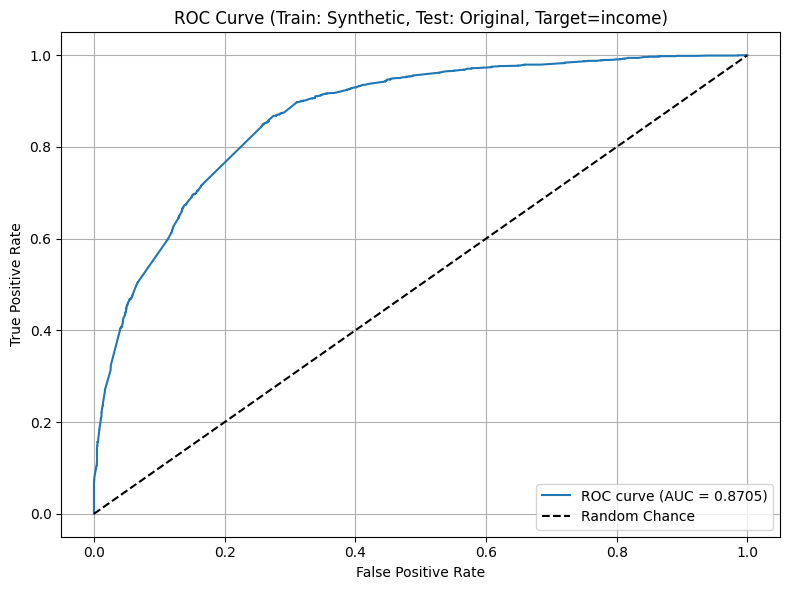


  Training on Original Data, Testing on Original Data with XGBoost...
  Accuracy (Train: Original, Test: Original with XGBoost): 0.8647
  Classification Report (Train: Original, Test: Original with XGBoost):
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      4945
        >50K       0.79      0.60      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.78      0.80      6513
weighted avg       0.86      0.86      0.86      6513

Saved confusion matrix plot as 'confusion_matrix_original_trained.png'


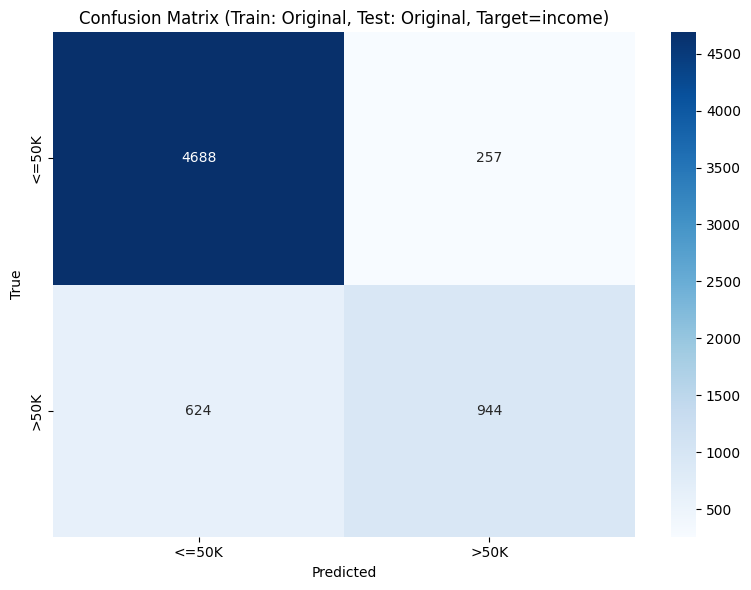

Saved ROC curve plot as 'roc_curve_original_trained.png'


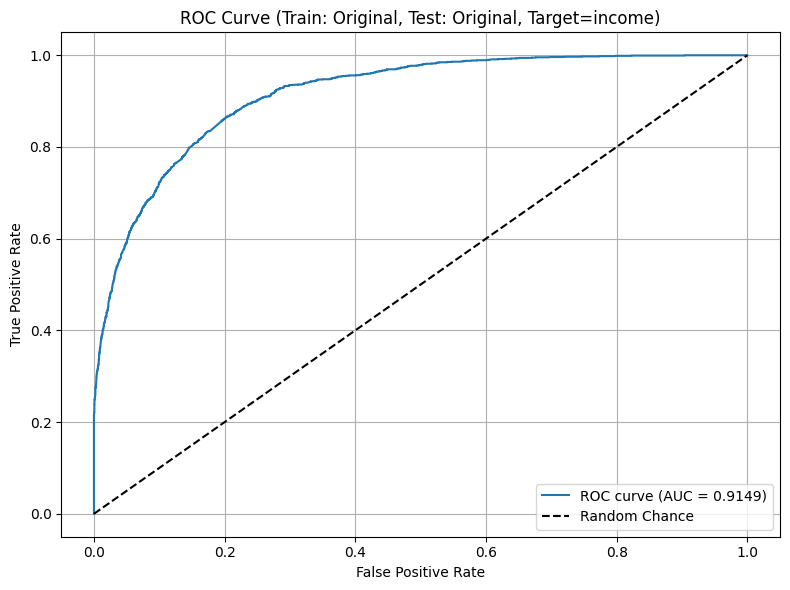


  Training on Synthetic Data, Testing on Original Data with SVM...
  Accuracy (Train: Synthetic, Test: Original with SVM): 0.8288
  Classification Report (Train: Synthetic, Test: Original with SVM):
              precision    recall  f1-score   support

       <=50K       0.85      0.95      0.89      4945
        >50K       0.73      0.46      0.56      1568

    accuracy                           0.83      6513
   macro avg       0.79      0.70      0.73      6513
weighted avg       0.82      0.83      0.81      6513

Saved confusion matrix plot as 'confusion_matrix_svm_synthetic_trained.png'


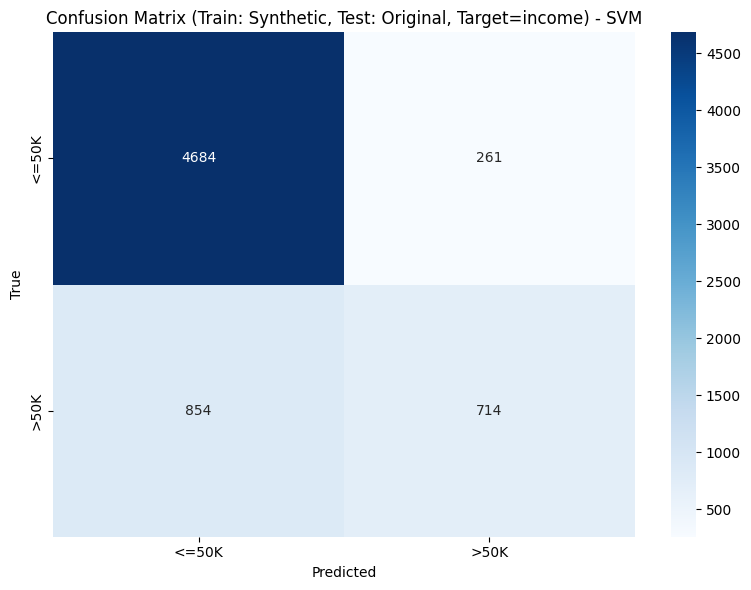

Saved ROC curve plot as 'roc_curve_svm_synthetic_trained.png'


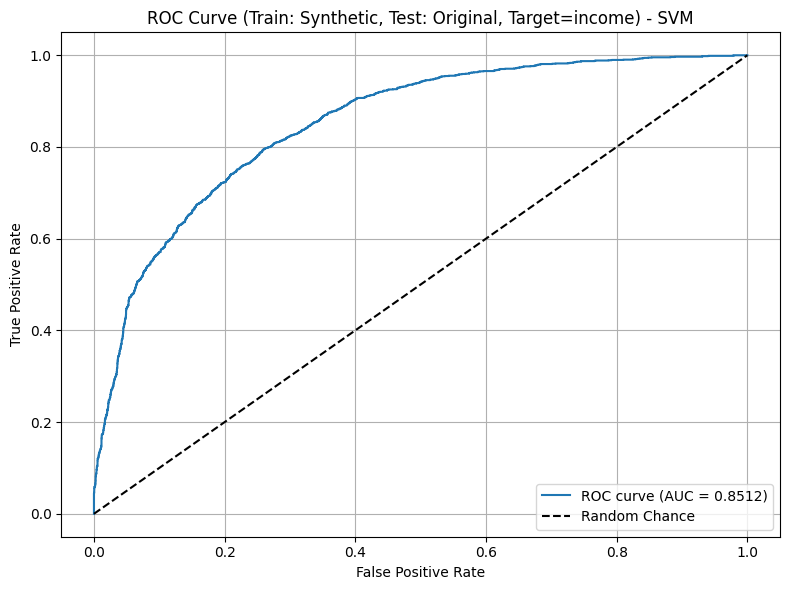


  Training on Original Data, Testing on Original Data with SVM...
  Accuracy (Train: Original, Test: Original with SVM): 0.8666
  Classification Report (Train: Original, Test: Original with SVM):
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.92      4945
        >50K       0.80      0.60      0.68      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.77      0.80      6513
weighted avg       0.86      0.87      0.86      6513


  ML Utility Comparison:
  Baseline Accuracy (Orig->Orig with XGBoost): 0.8647
  Synthetic Accuracy (Synth->Orig with XGBoost): 0.8302
  Accuracy Difference (XGBoost): 0.0345
  Baseline Accuracy (Orig->Orig with SVM): 0.8666
  Synthetic Accuracy (Synth->Orig with SVM): 0.8288
  Accuracy Difference (SVM): 0.0378

--- Script Finished ---


In [ ]:
#Homework 2 for the course Data Privacy and Security
#Name: Derara Senay Shanka 
#ID: D11315805
# The following code implements a differential privacy mechanism for generating synthetic data using noisy marginals.
# It includes functions for generating noisy marginals, making them consistent, and evaluating the synthetic data using machine learning models.
# The code also includes functions for plotting confusion matrices and ROC curves.
# The dataset used is the Adult Income dataset, and the code evaluates the utility of the synthetic data using XGBoost and SVM classifiers. 
# The code is designed to be run in a Python environment with the necessary libraries installed.
# Import necessary libraries

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC  # Import SVM
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings

warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]
    sensitivity = 1.0

    valid_columns = [col for col in columns if col in data.columns]
    if not valid_columns:
        print("Error: No valid columns found in data for marginal generation.")
        return marginals

    combs = list(itertools.combinations(valid_columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]

    if not combs:
        print(f"Warning: No valid combinations of size {k} found for the provided columns.")
        return marginals

    for comb in combs:
        try:
            if all(c in data.columns for c in comb):
                counts = data[list(comb)].value_counts().to_dict()
                noisy_counts = {}
                for key, count in counts.items():
                    noise = np.random.laplace(0, sensitivity / epsilon)
                    noisy_counts[key] = max(0, count + noise)
                marginals[comb] = noisy_counts
            else:
                print(f"Skipping marginal for {comb}: One or more columns not found in data.")
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent
def make_consistent(marginals, data, columns):
    synthetic_data = data.copy()
    for comb, noisy_counts in marginals.items():
        try:
            total_noisy_count = sum(noisy_counts.values())
            if total_noisy_count == 0:
                print(f"Warning: Noisy marginal for {comb} sums to zero. Skipping.")
                continue

            probs = {k: v / total_noisy_count for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = list(probs.values())

            prob_values = np.array(prob_values)
            prob_values /= prob_values.sum()

            sample_size = len(data)
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)

            for i in range(sample_size):
                sampled_key = keys[sampled_indices[i]]
                if not isinstance(sampled_key, tuple):
                    sampled_key = (sampled_key,)

                if len(sampled_key) == len(comb):
                    for j, col in enumerate(comb):
                        if col in synthetic_data.columns:
                            synthetic_data.at[i, col] = sampled_key[j]
                        else:
                            print(f"Warning: Column '{col}' from combination {comb} not found in synthetic_data during update.")
                else:
                    print(f"Warning: Length mismatch between sampled key {sampled_key} and combination {comb}. Skipping update for row {i}.")
        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")

    return synthetic_data



# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        if y_pred_proba.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
            try:
                auc = roc_auc_score(y_true, y_pred_proba[:, 1])
                plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
            except ValueError as e:
                print(f"Error calculating AUC for binary case: {e}. Skipping plot.")
                auc = float('nan')
        else:
            print("Error: Expected 2 columns in y_pred_proba for binary classification.")
            return
    else:
        auc_scores = []
        for i in range(n_classes):
            y_true_binary = (y_true == i).astype(int)
            if np.sum(y_true_binary) > 0 and np.sum(y_true_binary) < len(y_true):
                fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, i])
                try:
                    auc = roc_auc_score(y_true_binary, y_pred_proba[:, i])
                    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
                    auc_scores.append(auc)
                except ValueError as e:
                    print(f"Error calculating AUC for class {classes[i]}: {e}. Skipping this class.")
                    auc_scores.append(float('nan'))

        valid_auc_scores = [s for s in auc_scores if not np.isnan(s)]
        if valid_auc_scores:
            auc_macro = np.mean(valid_auc_scores)
            plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.4f}')
        else:
            print("Could not calculate Macro-average AUC.")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# --- Data Loading and Preprocessing ---
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.csv"
adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

try:
    data = pd.read_csv(data_path, names=adult_columns, sep=',\s*', header=None, engine='python', na_values='?')
    print("Dataset loaded successfully.")
    print(f"Initial dataset shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    print("Please update the 'data_path' variable with the correct location of 'adult.csv'.")
    exit(1)
except Exception as e:
    print(f"An error occurred loading the dataset: {e}")
    exit(1)

if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    print("Dropped 'fnlwgt' column.")

data = data.fillna('missing')
print(f"Dataset shape after handling missing values: {data.shape}")

columns = list(data.columns)
print("Dataset columns being used:", columns)

data = data.astype(str)
print("Converted all columns to string type for marginal processing.")

# --- Differential Privacy Parameters ---
epsilon_total = 1.0
num_marginals = 10
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total
k_marginal = 2

print(f"\nStarting DPSyn process with:")
print(f"  Total epsilon: {epsilon_total}")
print(f"  Number of {k_marginal}-way marginals: {num_marginals}")
print(f"  Epsilon per marginal: {epsilon_per_marginal:.4f}")

# --- Generate Synthetic Data ---
print(f"\nStep 1&2: Generating {num_marginals} noisy {k_marginal}-way marginals...")
marginals = generate_noisy_marginals(data, columns, k=k_marginal, epsilon=epsilon_per_marginal)

print("\nStep 3: Applying marginals to generate synthetic data...")
synthetic_data = make_consistent(marginals, data, columns)

output_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\synthetic_anonymized_adult.csv"
synthetic_data.to_csv(output_path, index=False)
print(f"\nSynthetic dataset generated and saved as '{output_path}'")
print(f"Synthetic dataset shape: {synthetic_data.shape}")

# --- Verification of Column Structure ---
print("\n--- Verifying Column Structure ---")
original_cols = list(data.columns)
synthetic_cols = list(synthetic_data.columns)

print("Original Data Columns:", original_cols)
print("Synthetic Data Columns:", synthetic_cols)

if original_cols == synthetic_cols:
    print("✅ Column names and order MATCH between original and synthetic data.")
else:
    print("⚠️ WARNING: Column names or order DIFFER between original and synthetic data.")

# --- Evaluation ---

def tvd(original_series, synthetic_series):
    """Calculates the Total Variation Distance between two categorical series."""
    try:
        original_series = original_series.astype(str)
        synthetic_series = synthetic_series.astype(str)

        orig_counts = original_series.value_counts(normalize=True)
        synth_counts = synthetic_series.value_counts(normalize=True)

        all_categories = orig_counts.index.union(synth_counts.index)

        orig_counts = orig_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)

        tvd_value = 0.5 * np.sum(np.abs(orig_counts - synth_counts))
        return tvd_value
    except Exception as e:
        print(f"Error computing TVD: {e}")
        return None

print("\n--- Evaluation: Utility Analysis ---")
print("1. Total Variation Distance (TVD) for selected 1-way marginals:")
tvd_results = {}
eval_columns = ['age', 'workclass', 'education', 'race', 'sex', 'income']

for col in eval_columns:
    if col in data.columns and col in synthetic_data.columns:
        tvd_value = tvd(data[col], synthetic_data[col])
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"  TVD for '{col}': {tvd_value:.4f}")
    else:
        print(f"  Skipping TVD for '{col}': Column not found in both datasets.")

print("\n2. Machine Learning Utility (XGBoost and SVM Classification):")
if 'income' in data.columns and 'income' in synthetic_data.columns:
    target_column = 'income'
else:
    target_column = None
    print("  'income' column not found in both datasets. Cannot perform classification task.")

if target_column:
    print(f"  Target variable: '{target_column}'")
    try:
        X_orig = data.drop(target_column, axis=1)
        y_orig = data[target_column]
        X_synth = synthetic_data.drop(target_column, axis=1)
        y_synth = synthetic_data[target_column]

        le = LabelEncoder()
        y_orig_encoded = le.fit_transform(y_orig)
        y_synth_encoded = le.transform(y_synth)
        n_classes = len(le.classes_)
        print(f"  Encoded target classes: {le.classes_}")

        X_orig_encoded = pd.get_dummies(X_orig)
        X_synth_encoded = pd.get_dummies(X_synth)

        common_cols = X_orig_encoded.columns.intersection(X_synth_encoded.columns)
        X_orig_aligned = X_orig_encoded[common_cols]
        X_synth_aligned = X_synth_encoded[common_cols]

        missing_in_synth = X_orig_aligned.columns.difference(X_synth_aligned.columns)
        for c in missing_in_synth:
            X_synth_aligned[c] = 0
        X_synth_aligned = X_synth_aligned[X_orig_aligned.columns]

        print(f"  Data shape after encoding/alignment: X_orig={X_orig_aligned.shape}, X_synth={X_synth_aligned.shape}")

        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
            X_orig_aligned, y_orig_encoded, test_size=0.2, random_state=42, stratify=y_orig_encoded
        )
        print(f"  Split original data: Train={X_train_orig.shape}, Test={X_test_orig.shape}")

        regex = re.compile(r"[|]|<", re.IGNORECASE)
        X_train_orig.columns = [regex.sub("_", col) for col in X_train_orig.columns]
        X_test_orig.columns = [regex.sub("_", col) for col in X_test_orig.columns]
        X_synth_aligned.columns = [regex.sub("_", col) for col in X_synth_aligned.columns]

        # Scenario 1: Train on SYNTHETIC data, Test on ORIGINAL data (TSTR)
        print("\n  Training on Synthetic Data, Testing on Original Data with XGBoost...")
        clf_xgb = XGBClassifier(
            objective='binary:logistic' if n_classes == 2 else 'multi:softmax',
            eval_metric='logloss' if n_classes == 2 else 'mlogloss',
            use_label_encoder=False,
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1
        )
        clf_xgb.fit(X_synth_aligned, y_synth_encoded)
        y_pred_synth_on_orig = clf_xgb.predict(X_test_orig)
        y_pred_proba_synth_on_orig = clf_xgb.predict_proba(X_test_orig)

        accuracy_synth = clf_xgb.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Synthetic, Test: Original with XGBoost): {accuracy_synth:.4f}")
        print("  Classification Report (Train: Synthetic, Test: Original with XGBoost):")
        print(classification_report(y_test_orig, y_pred_synth_on_orig, target_names=le.classes_))

        # Plot confusion matrix (Synthetic Trained)
        plot_confusion_matrix(
            y_test_orig, y_pred_synth_on_orig, le.classes_,
            f"Confusion Matrix (Train: Synthetic, Test: Original, Target={target_column})",
            "confusion_matrix_synthetic_trained.png"
        )

        # Plot ROC curve (Synthetic Trained)
        plot_roc_curve(
            y_test_orig, y_pred_proba_synth_on_orig, n_classes, le.classes_,
            f"ROC Curve (Train: Synthetic, Test: Original, Target={target_column})",
            "roc_curve_synthetic_trained.png"
        )

        # Scenario 2: Train on ORIGINAL data, Test on ORIGINAL data with XGBoost
        print("\n  Training on Original Data, Testing on Original Data with XGBoost...")
        clf_xgb.fit(X_train_orig, y_train_orig)
        y_pred_orig_on_orig = clf_xgb.predict(X_test_orig)
        y_pred_proba_orig_on_orig = clf_xgb.predict_proba(X_test_orig)

        accuracy_original = clf_xgb.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Original, Test: Original with XGBoost): {accuracy_original:.4f}")
        print("  Classification Report (Train: Original, Test: Original with XGBoost):")
        print(classification_report(y_test_orig, y_pred_orig_on_orig, target_names=le.classes_))

        # Plot confusion matrix (Original Trained)
        plot_confusion_matrix(
            y_test_orig, y_pred_orig_on_orig, le.classes_,
            f"Confusion Matrix (Train: Original, Test: Original, Target={target_column})",
            "confusion_matrix_original_trained.png"
        )

        # Plot ROC curve (Original Trained)
        plot_roc_curve(
            y_test_orig, y_pred_proba_orig_on_orig, n_classes, le.classes_,
            f"ROC Curve (Train: Original, Test: Original, Target={target_column})",
            "roc_curve_original_trained.png"
        )

        # --- Adding SVM Evaluation ---
        print("\n  Training on Synthetic Data, Testing on Original Data with SVM...")
        clf_svm = SVC(probability=True, random_state=42)  # SVM classifier
        clf_svm.fit(X_synth_aligned, y_synth_encoded)
        y_pred_svm_synth_on_orig = clf_svm.predict(X_test_orig)
        y_pred_proba_svm_synth_on_orig = clf_svm.predict_proba(X_test_orig)

        accuracy_svm_synth = clf_svm.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Synthetic, Test: Original with SVM): {accuracy_svm_synth:.4f}")
        print("  Classification Report (Train: Synthetic, Test: Original with SVM):")
        print(classification_report(y_test_orig, y_pred_svm_synth_on_orig, target_names=le.classes_))

        # Plot confusion matrix (SVM Trained)
        plot_confusion_matrix(
            y_test_orig, y_pred_svm_synth_on_orig, le.classes_,
            f"Confusion Matrix (Train: Synthetic, Test: Original, Target={target_column}) - SVM",
            "confusion_matrix_svm_synthetic_trained.png"
        )

        # Plot ROC curve (SVM Trained)
        plot_roc_curve(
            y_test_orig, y_pred_proba_svm_synth_on_orig, n_classes, le.classes_,
            f"ROC Curve (Train: Synthetic, Test: Original, Target={target_column}) - SVM",
            "roc_curve_svm_synthetic_trained.png"
        )

        # Scenario 2: Train on ORIGINAL data, Test on ORIGINAL data with SVM
        print("\n  Training on Original Data, Testing on Original Data with SVM...")
        clf_svm.fit(X_train_orig, y_train_orig)
        y_pred_svm_orig_on_orig = clf_svm.predict(X_test_orig)
        y_pred_proba_svm_orig_on_orig = clf_svm.predict_proba(X_test_orig)

        accuracy_svm_original = clf_svm.score(X_test_orig, y_test_orig)
        print(f"  Accuracy (Train: Original, Test: Original with SVM): {accuracy_svm_original:.4f}")
        print("  Classification Report (Train: Original, Test: Original with SVM):")
        print(classification_report(y_test_orig, y_pred_svm_orig_on_orig, target_names=le.classes_))

        # Compare Results
        print("\n  ML Utility Comparison:")
        print(f"  Baseline Accuracy (Orig->Orig with XGBoost): {accuracy_original:.4f}")
        print(f"  Synthetic Accuracy (Synth->Orig with XGBoost): {accuracy_synth:.4f}")
        print(f"  Accuracy Difference (XGBoost): {accuracy_original - accuracy_synth:.4f}")

        print(f"  Baseline Accuracy (Orig->Orig with SVM): {accuracy_svm_original:.4f}")
        print(f"  Synthetic Accuracy (Synth->Orig with SVM): {accuracy_svm_synth:.4f}")
        print(f"  Accuracy Difference (SVM): {accuracy_svm_original - accuracy_svm_synth:.4f}")

    except Exception as e:
        import traceback
        print(f"Error during classification evaluation: {e}")
        print(traceback.format_exc())

print("\n--- Script Finished ---")